# scVIDE: Single Cell Variational Inference for Designing Experiments

Here we illustrate the use of scVIDE for planning single-cell RNA-seq experiments. For this purpose, we use the data set of Wu et al. (2019) where we extract 200 genes and 384 cells to serve as a pilot data set. 

Before determining statistical power for the data, we need to set up scVIDE. First, using scVIDE requires Version 0.6.0 of scVI, which can be installed in Julia using Conda and PyCall:

`Conda.add("scvi=0.6.0", channel="bioconda")`

Additionally, the h5py package has to be on version 3.1.0:

`Conda.add("h5py=3.1")`

Since we had to slightly adapt scVI to be able to extract the ELBO of each cell, we provide the modified source code of scVI in this Github repository. This should be replaced with the scVI version stored in Julia's local Conda:

~/.julia/conda/3/lib/python3.9/site-packages/scvi

After that, you´re ready to use scVIDE.

In [1]:
# Import Julia packages
using Conda
using PyCall
using Random
using StatsBase
using DataFrames
using VegaLite
using CSV
using Serialization

In [2]:
# Import Python packages
random = pyimport("random")
os = pyimport("os")
scvi = pyimport("scvi")
scvi_dataset = pyimport("scvi.dataset")
scvi_models = pyimport("scvi.models")
scvi_inference = pyimport("scvi.inference")
torch = pyimport("torch")
scvi_inference_autotune = pyimport("scvi.inference.autotune")
hyperopt = pyimport("hyperopt")

/Users/martintreppner/.julia/conda/3/lib/python3.9/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


PyObject <module 'hyperopt' from '/Users/martintreppner/.julia/conda/3/lib/python3.9/site-packages/hyperopt/__init__.py'>

In [3]:
# Install scVIDE
using Pkg
Pkg.add(PackageSpec(url="https://github.com/MTreppner/scVIDE.jl"))
using scVIDE

    Updating git-repo `https://github.com/MTreppner/scVIDE.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
Precompiling project...
  ✓ scVIDE
  1 dependency successfully precompiled in 2 seconds (67 already precompiled)
┌ Info: Precompiling scVIDE [753c8826-9225-433f-ad6a-de02ffe72467]
└ @ Base loading.jl:1423
┌ Warning: Package scVIDE does not have Distributed in its dependencies:
│ - If you have scVIDE checked out for development and have
│   added Distributed as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with scVIDE
└ Loading Distributed into scVIDE from project dependency, future warnings for scVIDE are suppressed.


In [4]:
# Set number of genes, number of cells, and number of synthetic cells
n_genes = 200;
n_cells = 192;
n_cell_multiple = 3;

# Data repository
data_path = "/Users/martintreppner/Dropbox/PhD/scRNA_Power/wu/wu_200hvg.csv";

In [5]:
# Read data set
countmatrix = scvi_dataset.CsvDataset(data_path, save_path = "");

# Subsample data set 
Random.seed!(111);
scVIDE.subsample_scVI_cells!(countmatrix, 64);

[2022-01-13 15:05:22,715] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:05:22,808] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:05:22,811] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-01-13 15:05:22,811] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-01-13 15:05:22,818] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:05:22,819] INFO - scvi.dataset.dataset | Downsampled from 2072 to 2072 cells
[2022-01-13 15:05:24,169] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:05:24,169] INFO - scvi.dataset.dataset | Downsampled from 2072 to 64 cells


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/martintreppner/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


# Train scVI and generate synthetic data

In [6]:
# Set scVI hyperparamteres
n_epochs = 1000;
lr = 0.0001;
n_latent = 5;
n_hidden = 32;
n_layers = 1;
reconstruction_loss = "nb";
batch_size = 32;
dropout_rate = 0.1;
    
# Set up scVI model
vae = scvi_models.VAE(
        countmatrix.nb_genes, 
        n_latent=n_latent, 
        n_hidden=n_hidden,
        n_layers=n_layers,
        dropout_rate=dropout_rate,
        log_variational=true,
        reconstruction_loss=reconstruction_loss, 
);
        
trainer = scvi_inference.UnsupervisedTrainer(vae,
        countmatrix,
        frequency=1,
        n_epochs_kl_warmup= 50,
        batch_size=batch_size,
        use_cuda=true
);

trainer.show_progbar = false

# Train scVI
trainer.train(n_epochs=n_epochs,lr=lr);

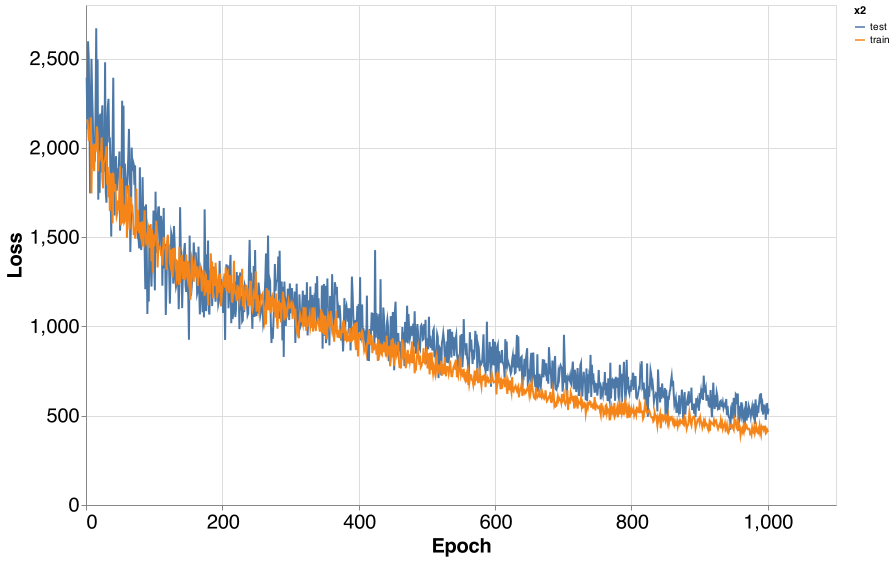

In [7]:
# Plot training progress
test_set = trainer.history["elbo_test_set"]
test_set = hcat(test_set, repeat(["test"], size(test_set,1)))
train_set = trainer.history["elbo_train_set"]
train_set = hcat(train_set, repeat(["train"], size(train_set,1)))
combined = vcat(test_set, train_set)
x_dat = vcat(collect(1:size(train_set,1)),collect(1:size(train_set,1)))
train_plot = DataFrame(hcat(combined,x_dat), :auto)

p = train_plot |>
@vlplot(
    width=750,
    height=500,
    :line, 
    x={"x3:q", title="Epoch", axis={titleFontSize=20, labelFontSize=20, tickCount=5}}, 
    y={"x1:q", title="Loss", axis={titleFontSize=20, labelFontSize=20, tickCount=5}},
    color={:x2}
)

## Generate synthetic data in varying sizes

In [8]:
# Set up posterior object from trained model
full = trainer.create_posterior(trainer.model, trainer.gene_dataset);
orig_n_cells = n_cell_multiple * n_cells;

# Generate synthetic data
Random.seed!(111);
gen_data_scvi = full.generate(batch_size = 64, n_samples=20);

# 64 cells reference
tmp = Array{Float64,2}(gen_data_scvi[1][:,:,1]');
tmp = DataFrame(tmp, :auto);
tmp |> CSV.write(string("synthetic_cells_",64,".csv"));

# Pase synthetic data sets to larger sample sizes
n_subset = n_cells;
n_paste = collect(1:trunc(Int,orig_n_cells/n_subset));
global gen_data_scvi_posterior = gen_data_scvi[1][:,:,1];
for j in 1:size(n_paste,1)

    global gen_data_scvi_posterior = vcat(gen_data_scvi_posterior, gen_data_scvi[1][:,:,j]);

    tmp = DataFrame(gen_data_scvi_posterior', :auto);
    tmp |> CSV.write(string("synthetic_cells_",j*n_cells,".csv"));
end;
rest = orig_n_cells % n_subset;
gen_data_scvi_posterior = Array{Float64,2}(vcat(gen_data_scvi_posterior,gen_data_scvi[1][1:rest,:,size(n_paste,1) + 1]));

tmp = DataFrame(gen_data_scvi_posterior', :auto);
tmp |> CSV.write(string("synthetic_cells_",orig_n_cells,".csv"));

# Train scVIDE and determine statistical power

In [21]:
# Set scVIDE hyperparameters
n_epochs = 200;
lr = 0.0001;
n_latent = 6;
n_hidden = 32;
n_layers = 1;
reconstruction_loss = "nb";
batch_size = 64;
dropout_rate = 0.1;
reference = false;
s = Int64(round(n_cells * 0.1));
B = 1;
seed = collect(4:10:500);
n_procs=7;
use_autotune=false;
subsampling=false;

space_train = Dict("lr"=>hyperopt.hp.choice("lr", [0.00005, 0.0001, 0.001, 0.005]))
space_model = Dict("n_hidden"=>hyperopt.hp.choice("n_hidden", [32, 64]), 
                            "n_latent"=>hyperopt.hp.choice("n_latent", [5, 10, 14]), 
                            "n_layers"=>hyperopt.hp.choice("n_layers", [1, 2, 3]),
                            "reconstruction_loss"=>hyperopt.hp.choice("reconstruction_loss", ["nb", "zinb"]))
space = Dict(["train_func_tunable_kwargs"=>space_train, "model_tunable_kwargs"=>space_model]);

Note: Running the following code chunk might take a bit of time.

In [22]:
# Run scVIDE für multiple sample sizes

# Train alternative and null model with jackstraw sampling on 64 cells as reference
data_path = string("synthetic_cells_",64,".csv")
jackstraw_scVI_out = scVIDE.jackstraw_scVI(;data_path=data_path,
                                            n_epochs=n_epochs,
                                            lr=lr,
                                            n_genes=n_genes,
                                            n_cells=n_cells,
                                            n_latent=n_latent,
                                            n_hidden=n_hidden,
                                            n_layers=n_layers,
                                            batch_size=batch_size,
                                            s=s,
                                            B=B,
                                            seed=seed,
                                            pretrained_model="",
                                            subsampling=subsampling,
                                            use_autotune=use_autotune,
                                            search_space=space
);
# Serialize jackstraw model
serialize(string("jackstraw_scVI",64,"cells"),jackstraw_scVI_out);
jackstraw_scVI_out = nothing;

for j in 1:n_cell_multiple
    data_path = string("synthetic_cells_",j*n_cells,".csv")

    # Train alternative model for synthetic data
    alternative_model_scVI_out = alternative_model_scVI(data_path=data_path,
                                                n_epochs=n_epochs, 
                                                lr=lr, 
                                                n_genes=n_genes, 
                                                n_cells=n_cells,
                                                n_latent = n_latent,
                                                n_hidden = n_hidden,
                                                n_layers = n_layers,
                                                batch_size = batch_size,
                                                pretrained_model="",
                                                subsampling=false,
                                                use_autotune=use_autotune,
                                                search_space=space
    );
    # Serialize alternative models
    serialize(string("alternative_models",j*n_cells,"cells"),alternative_model_scVI_out);
    alternative_model_scVI_out = nothing;
end;

[2022-01-13 15:24:48,172] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:24:48,181] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:24:48,182] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2022-01-13 15:24:48,182] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-01-13 15:24:48,182] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-01-13 15:24:48,183] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:24:48,183] INFO - scvi.dataset.dataset | Downsampled from 63 to 63 cells
[2022-01-13 15:24:48,183] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=200) <= self.nb_genes
[2022-01-13 15:24:49,929] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:24:49,933] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:24:49,934] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2022-01-13 15:24:49,934] INFO -

[2022-01-13 15:25:06,968] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:25:06,972] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:25:06,973] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2022-01-13 15:25:06,973] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-01-13 15:25:06,973] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-01-13 15:25:06,973] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:25:06,974] INFO - scvi.dataset.dataset | Downsampled from 63 to 63 cells
[2022-01-13 15:25:06,974] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=200) <= self.nb_genes
[2022-01-13 15:25:06,976] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:25:08,740] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:25:08,744] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:25:

[2022-01-13 15:25:26,075] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:25:26,079] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:25:26,080] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2022-01-13 15:25:26,080] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-01-13 15:25:26,080] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-01-13 15:25:26,080] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:25:26,080] INFO - scvi.dataset.dataset | Downsampled from 63 to 63 cells
[2022-01-13 15:25:26,080] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=200) <= self.nb_genes
[2022-01-13 15:25:26,082] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:25:26,082] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_ce

[2022-01-13 15:25:46,763] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:25:46,768] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:25:46,768] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2022-01-13 15:25:46,768] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-01-13 15:25:46,768] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-01-13 15:25:46,769] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:25:46,769] INFO - scvi.dataset.dataset | Downsampled from 63 to 63 cells
[2022-01-13 15:25:46,769] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=200) <= self.nb_genes
[2022-01-13 15:25:46,771] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:25:48,506] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:25:48,509] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:25:

[2022-01-13 15:26:06,049] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:26:06,053] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:26:06,053] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2022-01-13 15:26:06,054] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-01-13 15:26:06,054] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-01-13 15:26:06,054] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:26:06,054] INFO - scvi.dataset.dataset | Downsampled from 63 to 63 cells
[2022-01-13 15:26:06,054] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=200) <= self.nb_genes
[2022-01-13 15:26:06,065] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-01-13 15:26:07,779] INFO - scvi.dataset.csv | Preprocessing dataset
[2022-01-13 15:26:07,783] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2022-01-13 15:26:

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.7/Distributed/src/cluster.jl:1045


In [23]:
# Determine statistical power
reference = 64;
n_cells = 192;
p_val_all = DataFrame();
alpha=0.1;
pval_final = DataFrame();
n_cells_original = 192;
n_cell_multiple = 3;
  
# Load jackstraw model with 64 cells
jackstraw_scVI_out = deserialize(string("jackstraw_scVI",64,"cells"));

# Calculate difference in ELBOs for alternative model
d_alternative = (log.(jackstraw_scVI_out.alternative_model_scVI_out.elbo_per_cell_null) .- log.(jackstraw_scVI_out.alternative_model_scVI_out.elbo_per_cell));
d_alternative = d_alternative[.!(isnan.(d_alternative))];

# Extract ELBOs for jackstraw model
null_model_elbo = Array{Float64,1}();
null_model_elbo_reference = Array{Float64,1}();
null_model_jackstraw_indices = Array{Int64,1}();
for k in 1:size(seed,1)
    append!(null_model_elbo, jackstraw_scVI_out.null_model_scVI_out[k].elbo_per_cell_append)
    append!(null_model_elbo_reference, jackstraw_scVI_out.null_model_scVI_out[k].elbo_per_cell_append_null)
    append!(null_model_jackstraw_indices, jackstraw_scVI_out.null_model_scVI_out[k].jackstraw_indices)
end

# Calculate difference in ELBOs for jackstraw model
d_null = (log.(null_model_elbo_reference) .- log.(null_model_elbo));
d_null = d_null[.!(isnan.(d_null))];

emp_null_cdf = ecdf(d_null);
emp_pvals = 1 .- emp_null_cdf(d_alternative);
emp_true_alternatives = sum(emp_pvals .<= alpha) / size(d_alternative,1)

pval_combined = DataFrame(hcat(64,emp_true_alternatives), :auto);

for j in 1:n_cell_multiple
    alternative_model_scVI_out = deserialize(string("alternative_models",j*n_cells,"cells"))
            
    d_alternative = (log.(alternative_model_scVI_out.elbo_per_cell_null) .- log.(alternative_model_scVI_out.elbo_per_cell));

    pvals = 1 .- emp_null_cdf(d_alternative)
            
    emp_true_alternatives = sum(pvals .<= alpha) / size(d_alternative,1)
           
    pval = DataFrame(hcat(j * n_cells, emp_true_alternatives), :auto)
    pval_combined = vcat(pval_combined, pval)
end;

insertcols!(pval_combined, 3, :orig_cells => n_cells_original);
append!(pval_final,pval_combined);

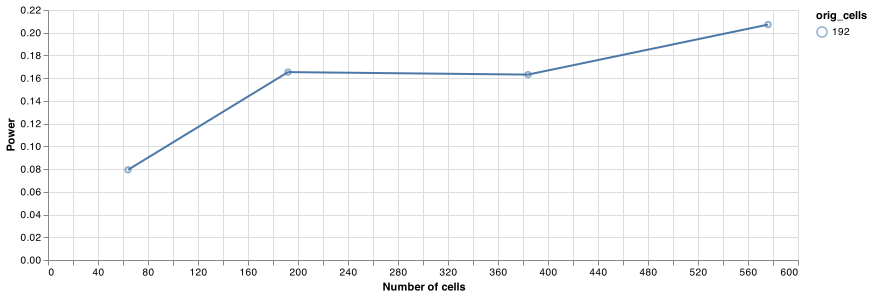

In [24]:
p = pval_final |>
@vlplot(
    transform=[
        {
        joinaggregate=[{
            op="mean",
            field="x2",
            as="mean_x2"
        }],
        groupby=["orig_cells"]
        }
    ]
) +
@vlplot(width=750,
    height=250,
    mark={
            :point,opacity=0.6
        },
    y={"x2:q", title = "Power"},
    x={"x1:q", title = "Number of cells"},
    color={"orig_cells:n"}
) +
@vlplot(
    mark=:line,
    x={"x1:q", title = "Number of cells"},
    y={aggregate="mean","x2:q"},
    color={"orig_cells:n"}
)

In [25]:
Conda.list()

# packages in environment at /Users/martintreppner/.julia/conda/3:
#
# Name                    Version                   Build  Channel
anndata                   0.6.22.post1               py_0    bioconda
appnope                   0.1.2            py39h6e9494a_2    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39h89e85a6_1    conda-forge
arpack                    3.7.0                hefb7bc6_2    conda-forge
asttokens                 2.0.5              pyhd8ed1ab_0    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.4.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
black                     21.12b0            pyhd8ed1ab_0   

┌ Info: Running `conda list` in root environment
└ @ Conda /Users/martintreppner/.julia/packages/Conda/1403Y/src/Conda.jl:129


In [26]:
Pkg.status()

      Status `~/.julia/environments/v1.7/Project.toml`
  [336ed68f] CSV v0.9.11
  [8f4d0f93] Conda v1.6.0
  [a93c6f00] DataFrames v1.3.1
  [7073ff75] IJulia v1.23.2
  [438e738f] PyCall v1.93.0
  [2913bbd2] StatsBase v0.33.14
  [112f6efa] VegaLite v2.6.0
  [753c8826] scVIDE v0.1.0 `https://github.com/MTreppner/scVIDE.jl#main`
